/home/wiktor/.pyenv/versions/3.11.3/envs/kaggling/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


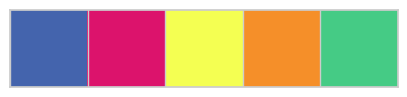

In [1]:
# essentials
import os
import pathlib
from copy import copy


import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, make_union, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SequentialFeatureSelector, RFECV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.impute import SimpleImputer, MissingIndicator, KNNImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, TweedieRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, make_scorer, roc_curve

from sklearn.preprocessing import Binarizer, Normalizer, RobustScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.multiclass import OneVsRestClassifier


# others
import xgboost as xgb 
import lightgbm as lgb

import optuna
import shap

RANDOM_SEED = 64

palette = ["#4464ad", "#dc136c", "#F4FF52", "#f58f29","#45cb85"]

sns.set_theme(style="whitegrid")
sns.set_palette(palette)
sns.palplot(palette)

In [2]:
def feature_engineering_1(df):
    # Balance
    df['balance_over_100k'] = df['Balance'] >= 100000
    df['balance_over_150k'] = df['Balance'] >= 150000

    # EstimatedSalary
    df["estimated_salary_under_50k"] = df["EstimatedSalary"] < 50000
    df["estimated_salary_50k_to_100k"] = (df["EstimatedSalary"] >= 50000) & (df["EstimatedSalary"] < 100000)
    df["estamated_salary_over_150k"] = df["EstimatedSalary"] >= 150000

    # NumOfProducts
    df["num_of_products_3_or_4"] = df["NumOfProducts"] >= 3

    # Age
    df["age_over_40"] = df["Age"] >= 40
    df["age_over_50"] = df["Age"] >= 50
    df["age_over_60"] = df["Age"] >= 60

    new_features = [
        "balance_over_100k",
        "balance_over_150k",
        "estimated_salary_under_50k",
        "estimated_salary_50k_to_100k",
        "estamated_salary_over_150k",
        "num_of_products_3_or_4",
        "age_over_40",
        "age_over_50",
        "age_over_60",
    ]
    for f in new_features:
        df[f] = df[f].astype("int")

    return df

In [3]:
IN_KAGGLE = False

kaggle_folder = "/kaggle/input/"
local_folder = "./data/"
input_folder = kaggle_folder if IN_KAGGLE else local_folder

train_df = pd.read_csv(input_folder + "playground-series-s4e1/train.csv", index_col="id")
test_df = pd.read_csv(input_folder + "playground-series-s4e1/test.csv", index_col="id")
submission_df = pd.read_csv(input_folder + "playground-series-s4e1/sample_submission.csv")
original_df = pd.read_csv(input_folder + "bank-customer-churn-prediction/Churn_Modelling.csv")
target_col = "Exited"

numeric_features = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

features_to_drop = ['CustomerId', 'Surname']

for f in features_to_drop:
    if f in numeric_features:
        numeric_features.remove(f)
    if f in categorical_features:
        categorical_features.remove(f)
    
    test_df = test_df.drop(columns=f)
    train_df = train_df.drop(columns=f)

def initial_feature_engineering(df):
    df['HasCrCard'] = df['HasCrCard'].astype('bool')
    df['IsActiveMember'] = df['IsActiveMember'].astype('bool')
    df['Gender'] = df['Gender'].map({ "Male": 0, "Female": 1}).astype("bool")
    # encode geography
    df = pd.get_dummies(df, columns=['Geography'])

    return df

train_df = initial_feature_engineering(train_df)
test_df = initial_feature_engineering(test_df)

train_df = feature_engineering_1(train_df)
test_df = feature_engineering_1(test_df)

X_train = train_df.drop(columns=target_col)
y_train = train_df[target_col]
X_test = test_df

In [4]:
lgbm_params = {'n_estimators': 631, 'learning_rate': 0.07492424154497802, 'max_depth': 3, 'reg_alpha': 5.323900045022921, 'reg_lambda': 5.220597472139037, 'min_child_weight': 1.6884481522503845, 'min_child_samples': 62, 'subsample': 0.6762768751029923, 'subsample_freq': 3, 'colsample_bytree': 0.9210890470992197, 'num_leaves': 60, 'max_bin': 592}
xgb_params = {'learning_rate': 0.014348229871720625, 'max_depth': 4, 'n_estimators': 400, 'gamma': 5.680012611123468e-05, 'subsample': 0.831669794155444, 'colsample_bytree': 0.8672951333636212, 'reg_alpha': 1.93331396215278e-05, 'reg_lambda': 4.9053061670211516e-06, 'min_child_weight': 7.059289455794295e-07}

In [5]:
model_1 =  StackingClassifier(
    estimators=[
        ("xgboost", xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1, **xgb_params)),
        ("lightgbm", lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1, **lgbm_params)),
        ("knn", KNeighborsClassifier(n_jobs=-1)),
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1),
    n_jobs=-1,
    verbose=1,   
)

model_2 = StackingClassifier(
    estimators=[
        ("xgboost", xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1, **xgb_params)),
        ("lightgbm", lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1, **lgbm_params)),
        ("logistic_regression", LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1)),
        ("sgd", SGDClassifier(random_state=RANDOM_SEED, loss="log_loss", n_jobs=-1)),
    ],
    final_estimator=lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1),
    n_jobs=-1,
    verbose=1,   
)

model_3 = lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1)

models = {
    "stacking_classifier": model_1,
    "stacking_classifier_lgbm": model_2,
    "lightgbm": model_3,
}

In [6]:

def create_pipeline(model, features=None):
    numeric_pipeline = Pipeline(
        [("scaler", StandardScaler())]
    )

    categorical_pipeline = Pipeline([
        #("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", drop='if_binary')),
    ])

    pipeline_numeric_features = numeric_features
    pipeline_categorical_features = categorical_features
    if features:
        # select only the features that are in features
        pipeline_numeric_features = [f for f in numeric_features if f in features]
        pipeline_categorical_features = [f for f in categorical_features if f in features]

    preprocessor = ColumnTransformer([
        ("numeric", numeric_pipeline, pipeline_numeric_features),
        #("categorical", categorical_pipeline, pipeline_categorical_features),
    ], remainder='passthrough')

    return Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model),
    ])

def train_models(models, X_train, y_train, parameters={}):
    trained_models = {}
    for model_name, model in tqdm(models.items()):
        model = create_pipeline(model)
        if model_name in parameters:
            model.set_params(**parameters[model_name])
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

def evaluate_models(models, X_val, y_val):
    # create a dataframe with "model_name", "accuracy", "precision", "recall", "area under the ROC curve"
    results_df = pd.DataFrame(columns=["model_name", "accuracy", "precision", "recall", "auc"])

    for model_name, model in tqdm(models.items()):
        print(model_name)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]
        
        results_df = pd.concat([
            results_df,
            pd.DataFrame({
                "model_name": [model_name],
                "accuracy": [model.score(X_val, y_val)],
                "precision": [sklearn.metrics.precision_score(y_val, y_pred)],
                "recall": [sklearn.metrics.recall_score(y_val, y_pred)],
                "auc": [sklearn.metrics.roc_auc_score(y_val, y_proba)],
            })
        ])
    return results_df

def plot_roc_curve(models, X_val, y_val):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    palette_to_use = sns.color_palette("husl", len(models))
    # for each model, plot the roc curve in the same plot, with other color
    for i, (model_name, model) in enumerate(models.items()):
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = roc_auc_score(y_val, y_proba)
        ax.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})", color=palette_to_use[i])
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve")
    # show legend
    ax.legend()

In [7]:
trained_models = {}

for model_name, model in tqdm(models.items()):
    model = clone_model(model)
    model = create_pipeline(model)
    model.fit(X_train, y_train)
    trained_models[model_name] = model

    # predict on test data
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]


    # create submission df

    submission_df = pd.DataFrame({
        "id": test_df.index,
        target_col: y_proba
    })
    submission_df.to_csv(f"./submission_{model_name}.csv", index=False)
submission_df.head()

  0%|          | 0/3 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.6s finished
